# Bahdanau 注意力

机器翻译问题： 通过设计一个基于两个循环神经网络的编码器-解码器架构， 用于序列到序列学习。 具体来说，循环神经网络编码器将长度可变的序列转换为固定形状的上下文变量， 然后循环神经网络解码器根据生成的词元和上下文变量 按词元生成输出（目标）序列词元。 然而，即使并非所有输入（源）词元都对解码某个词元都有用， 在每个解码步骤中仍使用编码相同的上下文变量。 有什么方法能改变上下文变量呢？

我们试着从 (Graves, 2013)中找到灵感： 在为给定文本序列生成手写的挑战中， Graves设计了一种可微注意力模型， 将文本字符与更长的笔迹对齐， 其中对齐方式仅向一个方向移动。 受学习对齐想法的启发，Bahdanau等人提出了一个没有严格单向对齐限制的 可微注意力模型 (Bahdanau et al., 2014)。 在预测词元时，如果不是所有输入词元都相关，模型将仅对齐（或参与）输入序列中与当前预测相关的部分。这是通过将上下文变量视为注意力集中的输出来实现的。

下面描述的Bahdanau注意力模型 将遵循 9.7节中的相同符号表达。这个新的基于注意力的模型与 9.7节中的模型相同, 只不过 (9.7.3)中的上下文变量 $\mathbf{c}$ 在任何解码时间步 $t^{\prime}$ 都会被 $\mathbf{c}_{t^{\prime}}$ 替换。假设输入 序列中有 $T$ 个词元, 解码时间步 $t^{\prime}$ 的上下文变量是注意力集中的输出:
$$
\mathbf{c}_{t^{\prime}}=\sum_{t=1}^T \alpha\left(\mathbf{s}_{t^{\prime}-1}, \mathbf{h}_t\right) \mathbf{h}_t
$$
其中，时间步 $t^{\prime}-1$ 时的解码器隐状态 $\mathbf{s}_{t^{\prime}-1}$ 是查询, 编码器隐状态 $\mathbf{h}_t$ 既是键, 也是值, 注意力权重 $\alpha$ 是使用 (10.3.2) 所定义的加性注意力打分函数计算的。

![](https://files.mdnice.com/user/23981/6cf25570-48ca-4fe2-b536-cf41137fee2e.png)

Bahdanau 注意力是一种用于神经机器翻译和序列生成任务的技术，旨在提高模型对输入序列中不同部分的关注度和重要性的准确性。

在传统的序列到序列模型中，模型会将整个输入序列编码成一个固定长度的向量，然后将该向量作为上下文，生成输出序列。但这种方法忽略了输入序列中各个位置之间的相互依赖性和信息重要性的差异性。

Bahdanau 注意力通过引入一个注意力机制，使得模型可以根据当前正在生成的目标单词，动态地计算出每个输入序列位置的重要性权重，并将其加权平均作为当前时刻的上下文，从而更好的捕捉输入序列中的信息，提高翻译或生成的质量。

具体来说，在 Bahdanau 注意力中，模型会通过一个对齐层（alignment layer）来计算当前时刻上下文向量。该对齐层会对输入序列中每个位置进行打分，然后对其进行归一化处理得到每个位置的权重，最终根据这些权重进行加权平均计算出当前时刻的上下文向量。

通过 Bahdanau 注意力的加入，模型可以更好地理解输入序列中各个部分的含义和重要性，从而提高了翻译或生成的质量和效果。

Bahdanau 注意力和传统的注意力模型是两种不同的注意力机制，它们在实现上有着一些区别。

传统的注意力模型主要使用点积注意力或双线性注意力计算每个时间步的权重分布。具体来说，对于每个时间步i，通过计算查询向量Q_i和键值对(K,V)的点积或双线性乘积得到一个分数，然后使用softmax函数将这些分数转化为该时间步对应的注意力权重。最后，在将权重和值V加权求和得到当前时间步的上下文向量。

Bahdanau 注意力模型则引入了额外的“对齐向量”(alignment vector)，该向量是根据当前时间步的上下文向量和所有编码器状态的加权和计算而来。这样，Bahdanau 注意力模型允许解码器更灵活地选择哪些编码器状态需要被关注，而不是只依赖于点积或双线性计算的结果。具体来说，Bahdanau 注意力模型的计算过程如下：

- 首先，对于每个时间步j，计算查询向量Q_j和所有编码器状态的相似度得分。
- 将这些得分通过softmax函数转化为注意力权重，得到对齐向量。
- 使用对齐向量和编码器状态的加权和来计算当前时间步的上下文向量。

因此，相较于传统的注意力模型，Bahdanau 注意力模型具备更强的关联能力并且能够动态地调整编码器状态之间的权重。这样可以提高机器翻译等任务的性能。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

下面看看如何定义Bahdanau注意力，实现循环神经网络编码器-解码器。 其实，我们只需重新定义解码器即可。 为了更方便地显示学习的注意力权重， 以下AttentionDecoder类定义了带有注意力机制解码器的基本接口。

In [2]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""

    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [4]:
#@save
class AttentionDecoder(Decoder):
    def __init__(self,**kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

@property注解是Python中的一种装饰器，它可以用来将一个方法转换成类属性。当使用@property注解时，你可以通过调用类方法的方式来获取属性值，而无需显式地调用该方法。

具体来说，@property注解被加在一个类方法上，这个方法会被称为getter方法，它负责获取某个类属性的值。在定义getter方法的同时，我们还需要定义另外一个名为setter方法的类方法，它负责设置类属性的值。

下面是一个简单的例子，其中我们使用@property注解来定义一个名为age的类属性，并且定义了与之对应的getter和setter方法：

```python
class Person:
    def __init__(self, age):
        self._age = age

    @property
    def age(self):
        return self._age

    @age.setter
    def age(self, value):
        if not isinstance(value, int):
            raise ValueError("Age must be an integer.")
        if value < 0 or value > 120:
            raise ValueError("Age must be between 0 and 120.")
        self._age = value
```
在这个例子中，我们通过@property注解将age方法转换成了类属性，并且使用了age.setter装饰器来定义了setter方法。由于age是一个类属性，我们可以通过直接调用Person.age的方式来获取或修改它的值：

```python
p = Person(20)
print(p.age)  # 输出：20

p.age = 30
print(p.age)  # 输出：30

p.age = "abc"  # 抛出 ValueError: Age must be an integer. 的异常
```

总的来说，@property注解是Python中一种非常方便的装饰器，它可以使得我们能够以类属性的形式来访问方法，从而提高了代码的可读性和简洁性。

接下来，让我们在接下来的Seq2SeqAttentionDecoder类中 实现带有Bahdanau注意力的循环神经网络解码器。 首先，初始化解码器的状态，需要下面的输入：

1. 编码器在所有时间步的最终层隐状态，将作为注意力的键和值；

2. 上一时间步的编码器全层隐状态，将作为初始化解码器的隐状态；

3. 编码器有效长度（排除在注意力池中填充词元）。

在每个解码时间步骤中，解码器上一个时间步的最终层隐状态将用作查询。 因此，注意力输出和输入嵌入都连结为循环神经网络解码器的输入。

In [5]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens,num_hiddens,num_hiddens,dropout)
        self.embedding=nn.Embedding(vocab_size,embed_size)
        self.rnn=nn.GRU(embed_size+num_hiddens,num_hiddens,num_layers,dropout=dropout)
        self.dense=nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,num_hiddens)
        enc_outputs,hidden_state,enc_valid_lens=state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X=self.embedding(X).permute(1,0,2)
        outputs,self._attentions_weights=[],[]
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query=torch.unsqueeze(hidden_state[-1],dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context=self.attention(query,enc_outputs,enc_outputs,enc_valid_lens)
            # 在特征维度上连接
            x=torch.cat((context,torch.unsqueeze(x,dim=1)),dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out,hidden_state=self.rnn(x.permute(1,0,2),hidden_state)
            outputs.append(out)
            self._attentions_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为(num_steps,batch_size,vocab_size)
        outputs=self.dense(torch.cat(outputs,dim=0))
        return outputs.permute(1,0,2),[enc_outputs,hidden_state,enc_valid_lens]

接下来，使用包含7个时间步的4个序列输入的小批量测试Bahdanau注意力解码器。

In [6]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

我们在这里指定超参数，实例化一个带有Bahdanau注意力的编码器和解码器， 并对这个模型进行机器翻译训练。 由于新增的注意力机制，训练要比没有注意力机制的 9.7.4节慢得多。

KeyboardInterrupt: 

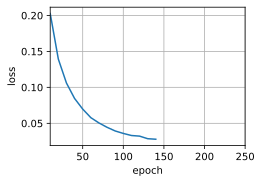

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

模型训练后，我们用它将几个英语句子翻译成法语并计算它们的BLEU分数。

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

In [ ]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

训练结束后，下面通过可视化注意力权重 会发现，每个查询都会在键值对上分配不同的权重，这说明 在每个解码步中，输入序列的不同部分被选择性地聚集在注意力池中。

In [ ]:
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')
